### Imports

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import stats, integrate
import csv
import os

import warnings
warnings.filterwarnings("ignore")

from functions import*
from algorithm_iteration import *

### Import dataset

In [12]:
#Acessing the folders and selecting the dataset to analyse
folders = []
path = os.getcwd()
obj = os.scandir(path)
for entry in obj:
    if entry.is_dir():
        folders.append(entry.name)

#dropdown menu to select dataset
print('Select dataset to analyze: ')
dataset_folder = widgets.RadioButtons(
    options=folders,
    description='Folders: ',
    disabled=False,
    layout=widgets.Layout(width='100%'))
display(dataset_folder)

Select dataset to analyze: 


RadioButtons(description='Folders: ', layout=Layout(width='100%'), options=('.ipynb_checkpoints', 'KT_B0034_BC…

In [57]:
#Creating new path with the selected folder and getting the names of the data files
new_path = path + '\\' + dataset_folder.value
files = os.listdir(new_path)
for file in files:
    if 'OD' in file:
        OD_file = file
    elif 'RFP' in file:
        RFP_file = file
    elif 'GFP' in file:
        GFP_file = file
    elif 'SAMPLES' in file:
        samples_file = file
        
#Assigning new paths to each data file and assigning
#the corresponding data structure for further analysis
DF_def = {}
dfs_names = []

OD_path = new_path + '\\' + OD_file
DF_def['OD'] = pd.read_csv(OD_path, index_col=0)
dfs_names.append('OD')

try:
    RFP_path = new_path + '\\' + RFP_file
    DF_def['RFP'] = pd.read_csv(RFP_path, index_col=0)
    dfs_names.append('RFP')
except:
    pass
try:
    GFP_path = new_path + '\\' + GFP_file
    DF_def['GFP'] = pd.read_csv(GFP_path, index_col=0)
    dfs_names.append('RFP')
except:
    pass

samples_path = new_path + '\\' + samples_file
f = open(samples_path, 'r')
lines = f.readlines()
f.close()
samples_input_str = str(lines)

#defining time and bouts
time = np.array(DF_def['OD'].index)
bouts = 0.5

#Creating the sample-well strcuture
samples = text_to_sample(samples_input_str)

samples_def = []
sample_names = []
blanks_def = []
wells_def = []


for line in samples:
    wells = sample_to_wells(line)
    wells_temp = []
    for i, well in enumerate(wells):
        if i == 0:
            sample_name = well
            if sample_name == 'blank':
                pass
            else:
                sample_names.append(sample_name)
        else:
            wells_temp.append(well)
            if sample_name == 'blank':
                pass
            else:
                wells_def.append(well)
    
    if sample_name == 'blank':
        blanks_def.append((sample_name, wells_temp))
    else:
        samples_def.append((sample_name, wells_temp))

# Plate analysis workflow

### Blank subtraction

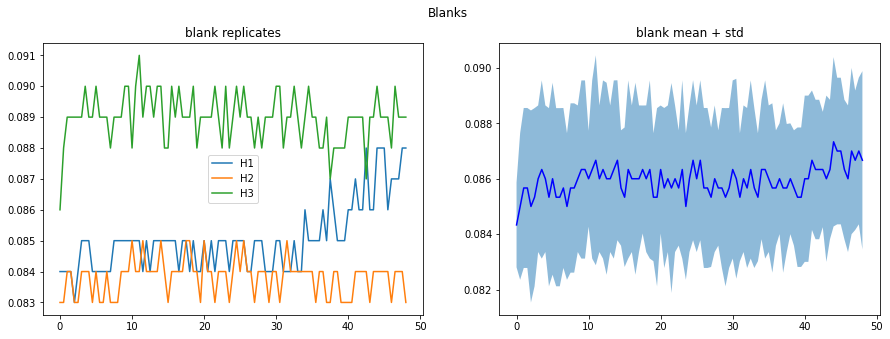

To remove replicates, uncheck the corresponding box above


In [58]:
if len(blanks_def) <= 1:
    blk_means = pd.DataFrame()
    blk_stds = pd.DataFrame()
    
    for blk in blanks_def:
        dataframe_self = DF_def['OD']
        wells = blk[1]
        blk_means = pd.concat([blk_means, dataframe_self[wells].mean(axis=1)], axis=1)
        blk_stds = pd.concat([blk_stds, dataframe_self[wells].std(axis=1)], axis=1)
    blk_means.columns = ['blank']
    blk_stds.columns = ['blank']
    
for blk in blanks_def:
    wells = blk[1]
    blk = blk[0]
    dataset_raw = DF_def['OD']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Blanks')
    ax2.plot(time, blk_means[blk], 'b-')
    ax2.fill_between(time, blk_means[blk]+blk_stds[blk], blk_means[blk]-blk_stds[blk], alpha=0.5)
    ax2.set_title((blk + ' mean + std'))

    for i in range(len(wells)):
        ax1.plot(time, dataset_raw[wells[i]], label=wells[i])
    ax1.set_title((blk + ' replicates'))
    ax1.legend()
    plt.show()

In [59]:
#Run only once if DF_def is not recalculated. You might be subtracting the BLK several times

#drop every well that is not in samples
for dataframe in DF_def:
    for well in DF_def[dataframe]:
        if well not in wells_def:
            DF_def[dataframe] = DF_def[dataframe].drop(well, axis=1)

#subtract BLK means to growth dataset
DF_noblk = DF_def['OD'].sub(list(blk_means['blank']), axis=0)
DF_def.update({'OD': DF_noblk})

#create growth rate dataset
DF_gr = pd.DataFrame()
DF_gr_prev = np.log(DF_noblk.astype(float)) #convert OD into ln OD
for c in DF_gr_prev:
    grad = np.gradient(DF_gr_prev[c], bouts) #gradient of ln OD
    DF_gr[c] = grad #store gradient of each well in a column with the well as header
DF_gr.index = time
DF_def.update({'Growth rate' : DF_gr})

#create dynamic activity dataset
for name in dfs_names:
    if name == 'OD': #this is done to every fluorescence dataset (not for growth)
        pass
    else:
        DF_PAdyn  = pd.DataFrame()
        DF_PAdyn_prev  = pd.DataFrame()
        DF_fp = DF_def[name]
        for c in DF_fp:
            grad = np.gradient(DF_fp[c], bouts) #gradient of fluorescence
            DF_PAdyn_prev[c] = grad #store gradient of each well in a column with the well as header

        DF_PAdyn_prev.index = time
            
        DF_PAdyn = DF_PAdyn_prev.div(DF_def['OD']) #divide growth values to gradient of fluorescence
        s = str('Dynamic Activity ' + name)
        DF_def.update({s : DF_PAdyn})

## Data filtering module

### Crop values

Crop data until (h):15


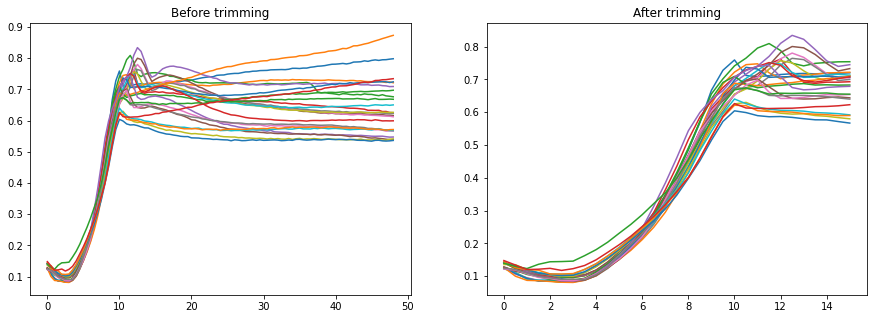

In [60]:
#Trim first to compute outliers and algorithm of the trimmed data
#(we used 15h for KT and 30h for W)
print('WARNING: This action is irreversible, deleted values cannot be recovered unless restart')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(DF_def['OD'])
ax1.set_title('Before trimming')

trim = float(input('Crop data until (h):'))
for key in DF_def.keys():
    DF_def[key] = DF_def[key][:trim]
for i, value in enumerate(time):
    if value == trim:
        time = time[:i+1]
        
ax2.plot(DF_def['OD'])
ax2.set_title('After trimming')
plt.show()

### Outliers

Number of std above the z-scores mean for outlier cutoff: 3

 Outliers found: ['G11']


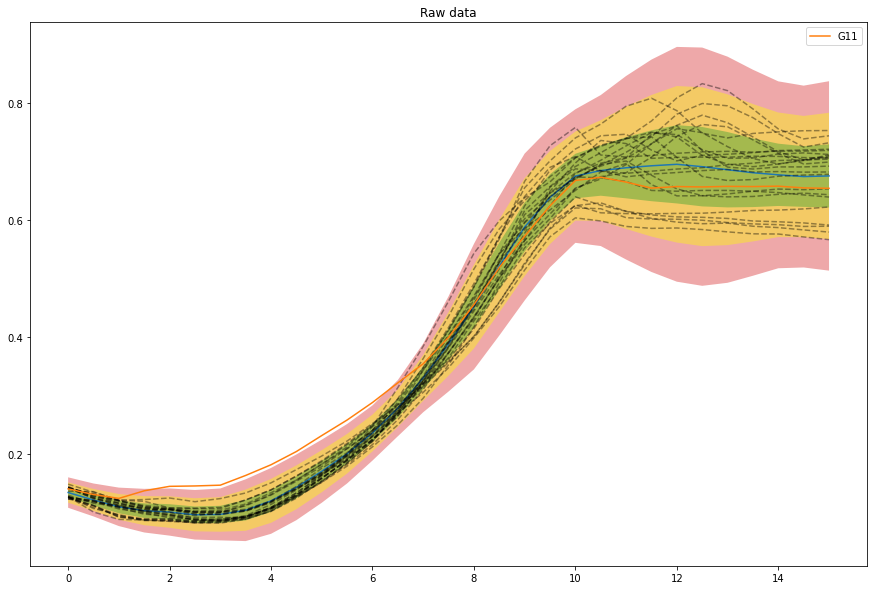

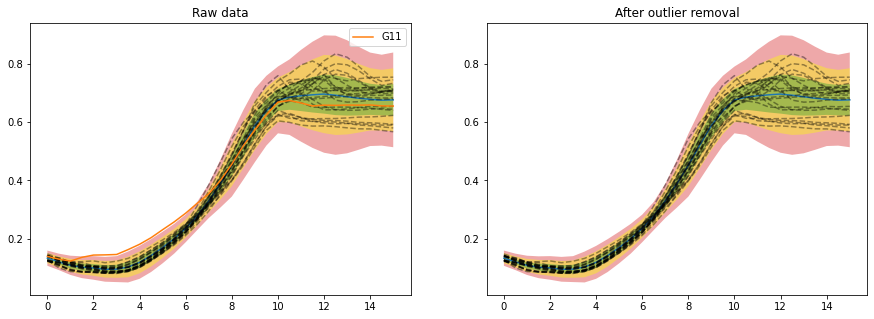

In [61]:
#Compute z-scores for every individual sample in the data (takes into account trimming)
#and compare it with the mean of the whole plate. Stablish a cut-off level based on
#a number of std above or below the mean and eliminate this well data from the dataframes
#(we used a value of 3 stds above and below the mean to indentify outliers as Zeevi et al.)

DF_def_inverted = DF_def['OD'].transpose()

zgen = []
for timepoint in DF_def_inverted.columns:
    data = DF_def_inverted[timepoint]
    z = []
    for i in range(len(data)):
        target = data[i]
        data_copy = list(data).copy()
        data_copy.remove(target)
        sample_mean = np.mean(data_copy)
        sample_std = np.std(data_copy)
        #z_score = (target - sample_mean)/sample_std #shouldn't this be an abs()?
        z_score = (abs(target - sample_mean))/sample_std
        z.append(z_score)
    zgen.append(z)

zscores_dict = {}
for idx, sample in enumerate(DF_def_inverted.index):
    temp_zscore = []
    for timepoint in zgen:
        sample_zscore = timepoint[idx]
        temp_zscore.append(sample_zscore)
    zscores_dict.update({sample : sum(temp_zscore)})
    
zscore_mean = np.mean(list(zscores_dict.values()))
zscore_std = np.std(list(zscores_dict.values()))

std_input_val = int(input('Number of std above the z-scores mean for outlier cutoff: '))
t = zscore_mean + std_input_val * zscore_std
threshold = []
for well in zscores_dict:
    if zscores_dict[well] < t:
        threshold.append(well)

outliers = []        
for i in list(zscores_dict):
    if i not in threshold:
        outliers.append(i)

if len(outliers) == 0:
    print('\nNo outliers found for that cutoff level')
else:
    print('\n Outliers found: %s' %outliers)
    
all_mean = DF_def['OD'].mean(axis=1)
all_std = DF_def['OD'].std(axis=1)

fig,ax = plt.subplots(figsize=(15,10))

ax.plot(time, all_mean)
ax.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:red', alpha=0.4)
ax.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.4)
ax.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.4)

for sample in threshold:
    ax.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4)   
    ax.set_title('Raw data')  
for out in outliers:
    ax.plot(time, DF_def['OD'][out], '-', label=out)
    ax.legend()
    
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(time, all_mean)
ax1.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:red', alpha=0.4)
ax1.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.4)
ax1.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.4)

ax2.plot(time, all_mean)
ax2.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:red', alpha=0.4)
ax2.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.4)
ax2.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.4)
for sample in threshold:
    ax1.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4)   
    ax1.set_title('Raw data')
for out in outliers:
    ax1.plot(time, DF_def['OD'][out], '-', label=out)
    ax1.legend()
for sample in threshold:
    ax2.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4, label=sample)
    ax2.set_title('After outlier removal')
plt.show()

In [62]:
#Update the samples if some outliers have been identified
samples_def_copy = samples_def.copy()
for sample in samples_def:
    wells = sample[1]
    for out in outliers:
        try:
            wells.remove(out)
        except:
            pass
samples_def = samples_def_copy

print('Samples:\n')
print(*samples_def, sep='\n')

print('\n\nBlanks:\n')
print(*blanks_def, sep='\n')

Samples:

('B0034', ['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
('BCD2', ['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])
('BCD12', ['F7', 'F8', 'F9', 'F10', 'F11', 'F12'])
('RBSDummy', ['G7', 'G8', 'G9', 'G10', 'G12'])


Blanks:

('blank', ['H1', 'H2', 'H3'])


## Time window calculation

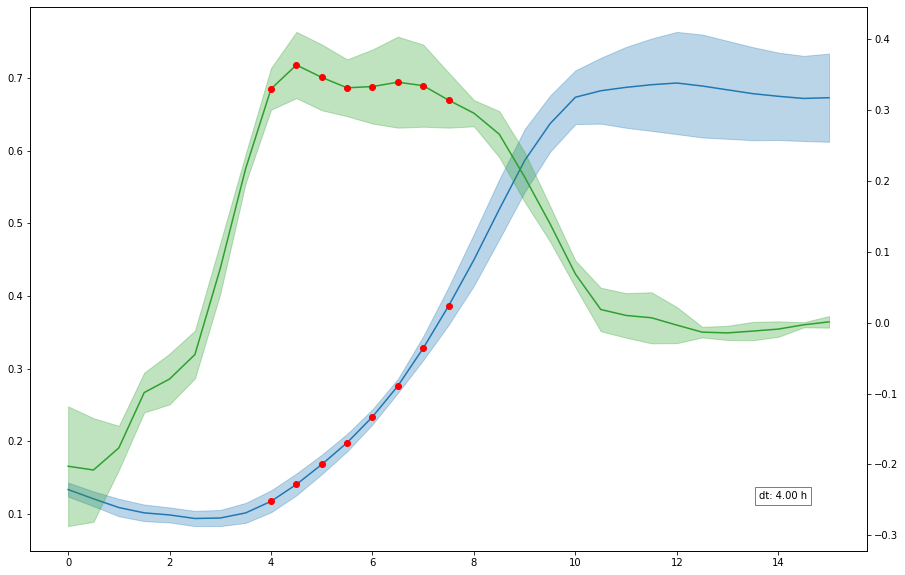

In [66]:
#create new dataframes for each dataset: mean and std for each timepoint
DF_means = {}
DF_stds = {}

#iterating through datasets
for dataframe in DF_def:
    dataframe_self = DF_def[dataframe]
    df_means = pd.DataFrame()
    df_stds = pd.DataFrame()
    
    #iterating through samples
    for sample in samples_def:  
        wells = sample[1]
        df_means = pd.concat([df_means, dataframe_self[wells].mean(axis=1)], axis=1)
        df_stds = pd.concat([df_stds, dataframe_self[wells].std(axis=1)], axis=1)
    df_means.columns = sample_names
    df_stds.columns = sample_names
    DF_means.update({dataframe : df_means})
    DF_stds.update({dataframe : df_stds})
    
#create mean of growth of the whole plate
m = DF_means['OD'].mean(axis=1)
std = DF_means['OD'].std(axis=1) 

gr_m = DF_means['Growth rate'].mean(axis=1)
gr_std = DF_means['Growth rate'].std(axis=1)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(time, m, color='tab:blue')
ax.fill_between(time, m+std, m-std, alpha=0.3, color='tab:blue')
ax1 = ax.twinx()
ax1.plot(time, gr_m, color='tab:green')
ax1.fill_between(time, gr_m+gr_std, gr_m-gr_std, alpha=0.3, color='tab:green')

algorithm_tpoints_sample = {}
algorithm_wpoints_sample = {}
algorithm_dt_sample = {}
for sample in DF_means['OD']:
    data = m
    alg = algorithm_iteration(data, 1, bouts=bouts, doub_time=2, c=3, sn=('%s - %s' %(sample[0], well)))
    time_pts = alg[2]
    w_idcs = alg[1]
    dt = alg[8]
    algorithm_tpoints_sample.update({sample : time_pts})
    algorithm_wpoints_sample.update({sample : w_idcs})
    algorithm_dt_sample.update({sample : dt})

alg = algorithm_iteration(m, 1, bouts=bouts, doub_time=2, c=3, sn=('%s - %s' %(sample[0], well)))
ax.plot(alg[2], m[alg[2]], 'ro')
ax1.plot(alg[2], gr_m[alg[2]], 'ro')
ax1.text(0.9, 0.1,('dt: %3.2f h' %alg[8]), transform=ax1.transAxes,
                 bbox=dict(facecolor='w', alpha=0.5), va='center', ha='center')

plt.show()

## Data visualization

In [67]:
#dropdown menu to select sample to be plotted
selector = widgets.RadioButtons(
    options=[name for name in DF_def],
    description='Dataset: ',
    disabled=False)
display(selector)

RadioButtons(description='Dataset: ', options=('OD', 'RFP', 'Growth rate', 'Dynamic Activity RFP'), value='OD'…

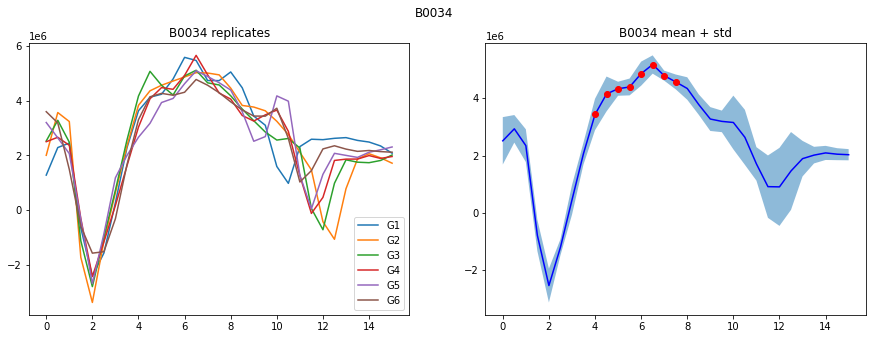

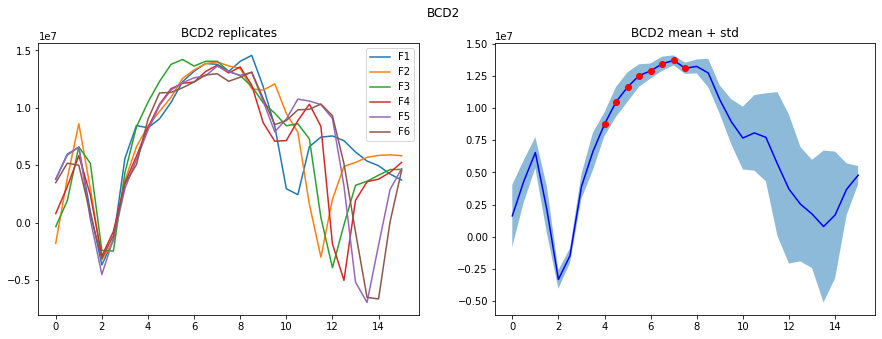

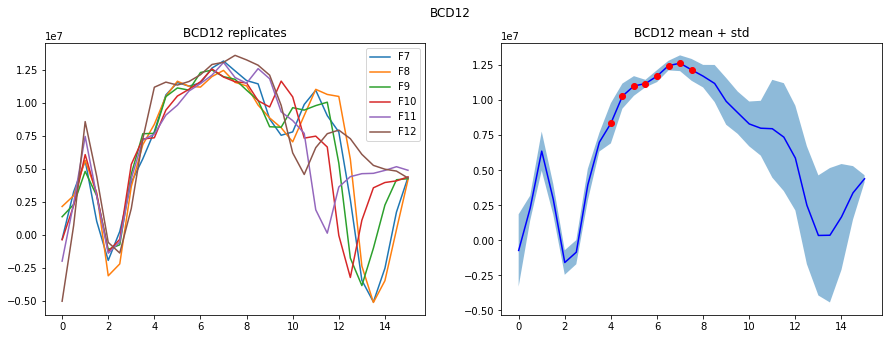

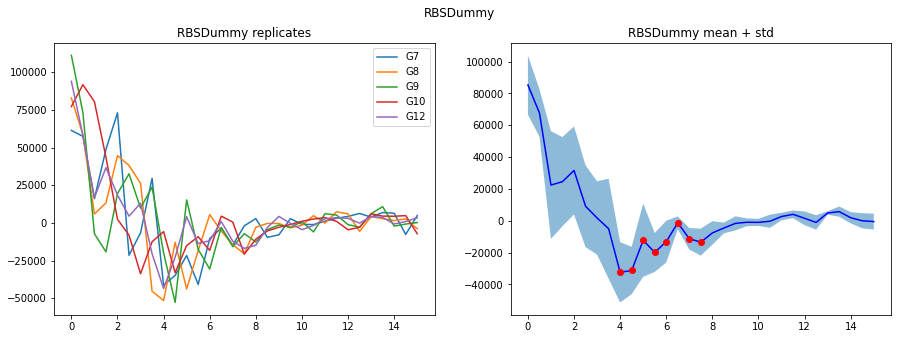

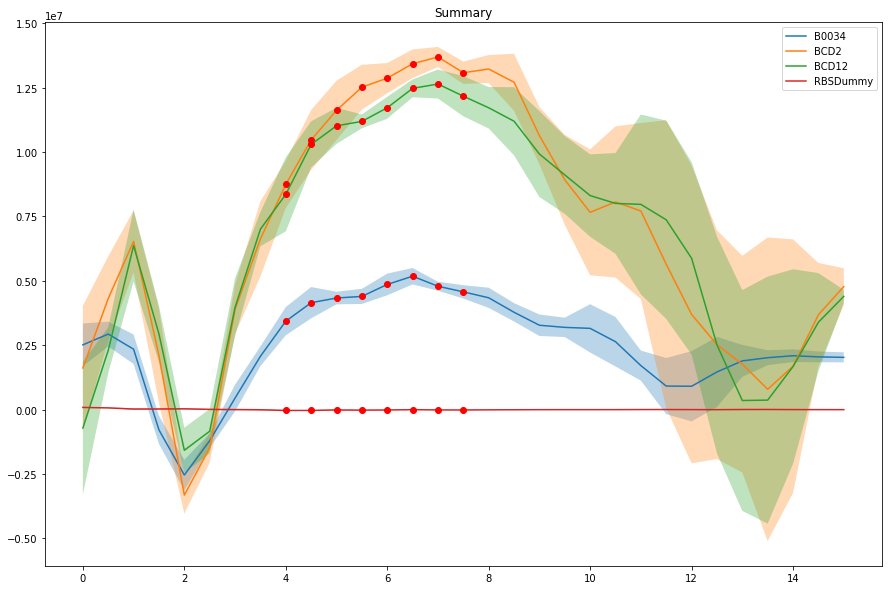

To remove replicates, uncheck the corresponding box above


In [71]:
#plot each replicate and the mean + std
dataset = selector.value

for sample in samples_def:
    wells = sample[1]
    sample = sample[0]
    dataset_raw = DF_def[dataset]
    dataset_means = DF_means[dataset]
    dataset_stds = DF_stds[dataset]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(sample)
    ax2.plot(time, dataset_means[sample], 'b-')
    ax2.fill_between(time, dataset_means[sample]+dataset_stds[sample], dataset_means[sample]-dataset_stds[sample], alpha=0.5)
    ax2.set_title((sample + ' mean + std'))
    
    alg_time = algorithm_tpoints_sample[sample]
    ax2.plot(alg_time, dataset_means[sample][alg_time], 'ro')
    
    for i in range(len(wells)):
        ax1.plot(time, dataset_raw[wells[i]], label=wells[i])
    ax1.set_title((sample + ' replicates'))
    ax1.legend()
    plt.show()
    
fig, ax = plt.subplots(figsize=(15,10))
for sample in samples_def:
    sample = sample[0]
    alg_time = algorithm_tpoints_sample[sample]
    ax.plot(time, DF_means[dataset][sample], label=sample)
    ax.plot(alg_time, DF_means[dataset][sample][alg_time], 'ro')
    ax.fill_between(time, dataset_means[sample]+dataset_stds[sample], dataset_means[sample]-dataset_stds[sample], alpha=0.3)
    ax.legend()
    ax.set_title('Summary')
plt.show()

## Growth rate computation

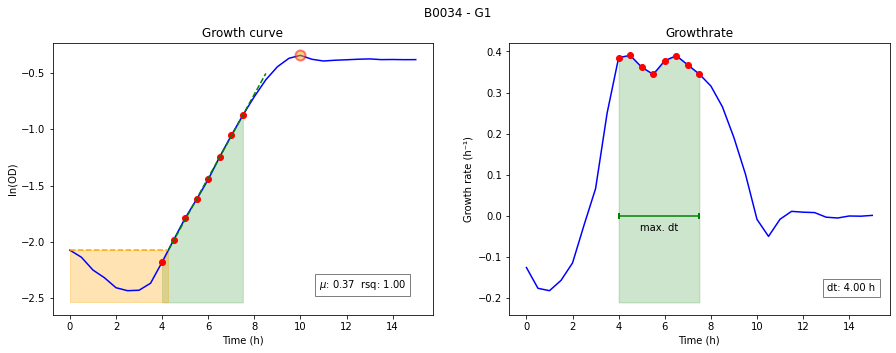

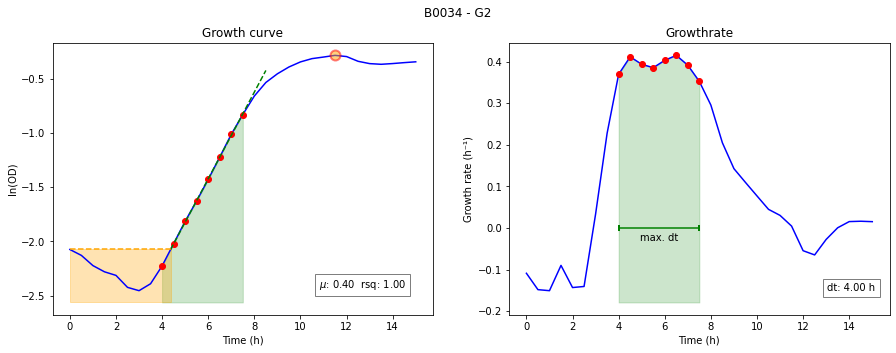

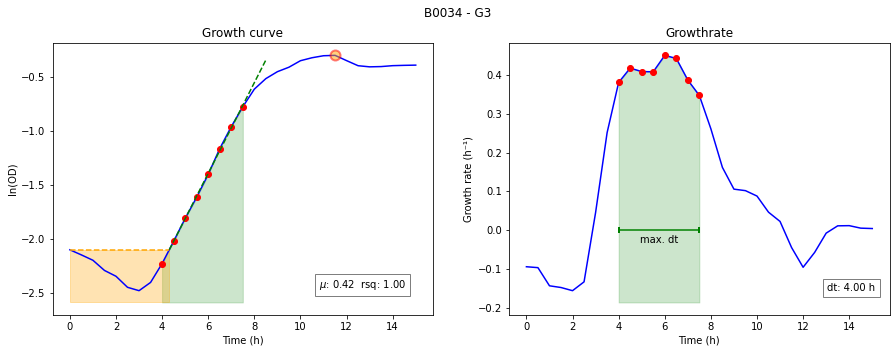

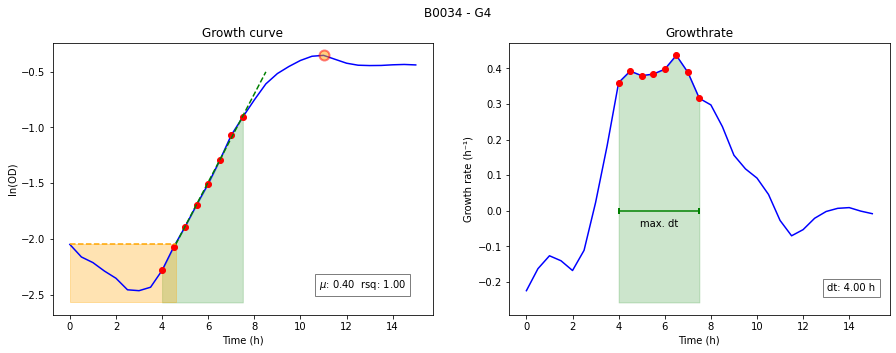

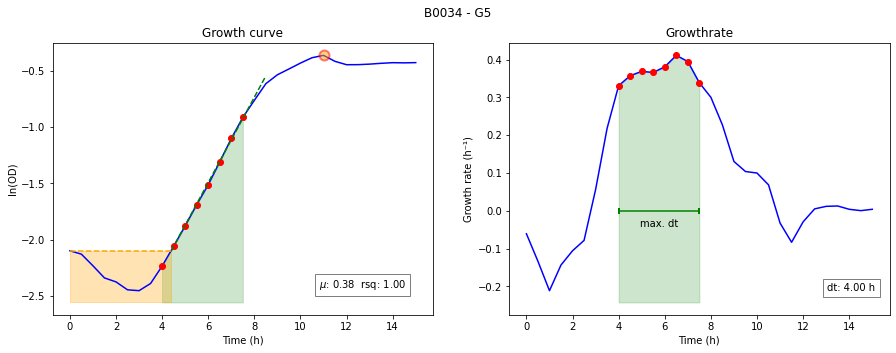

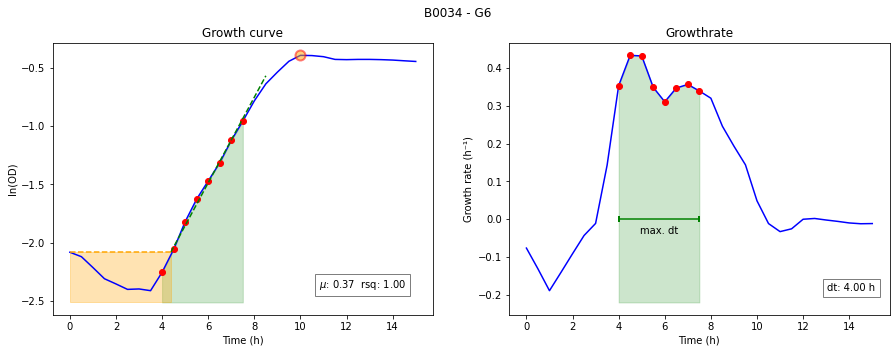

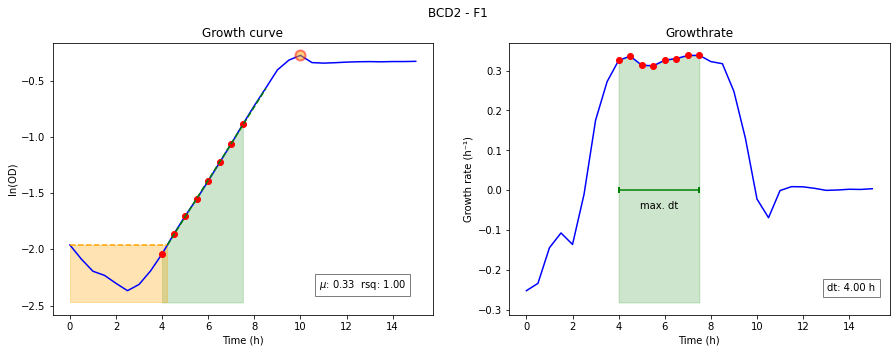

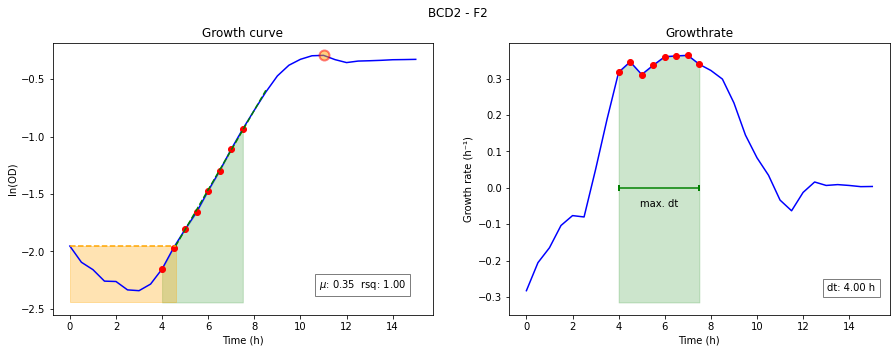

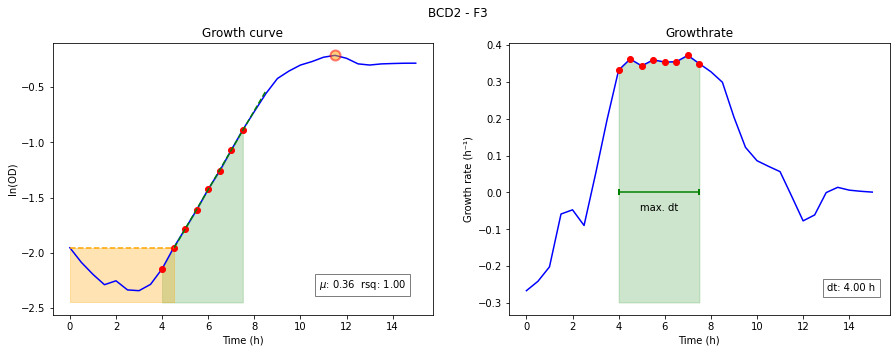

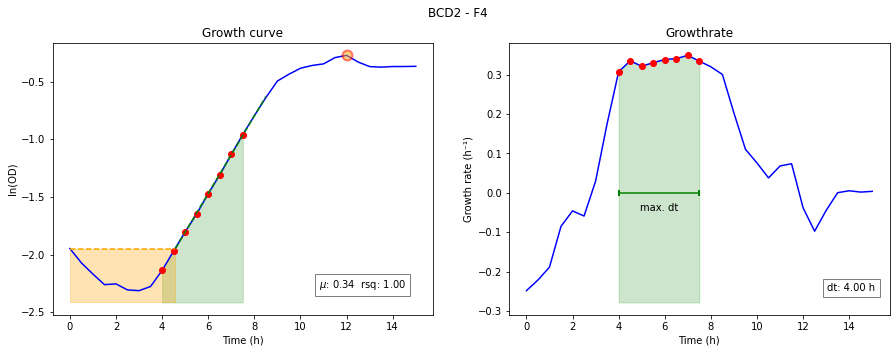

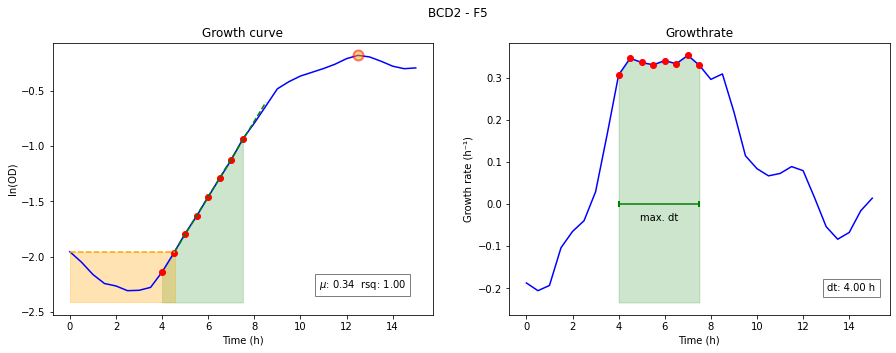

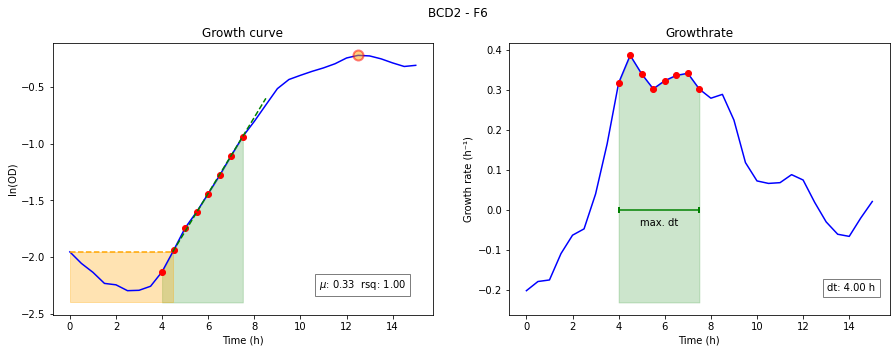

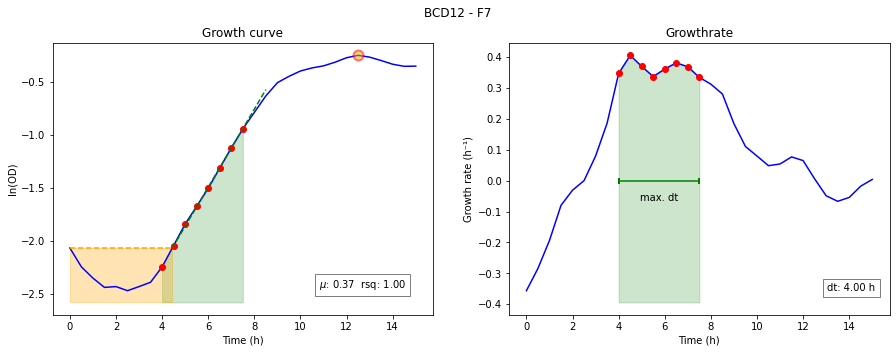

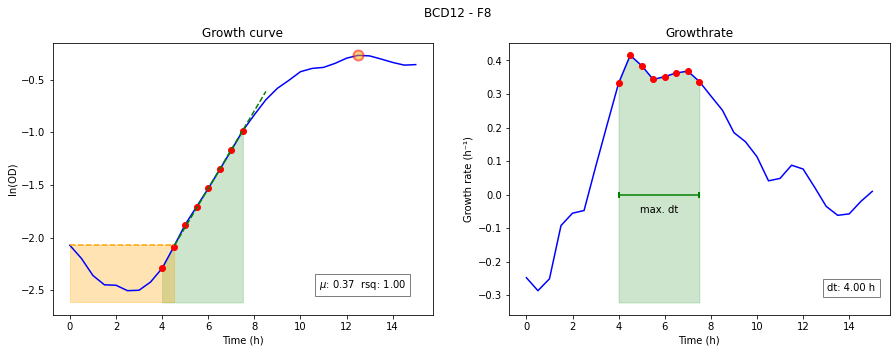

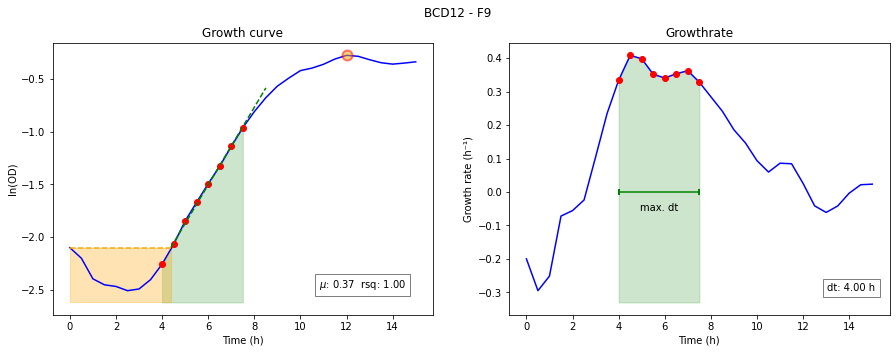

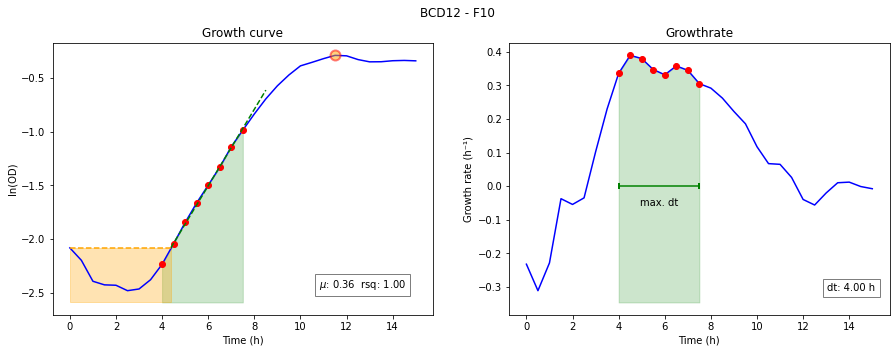

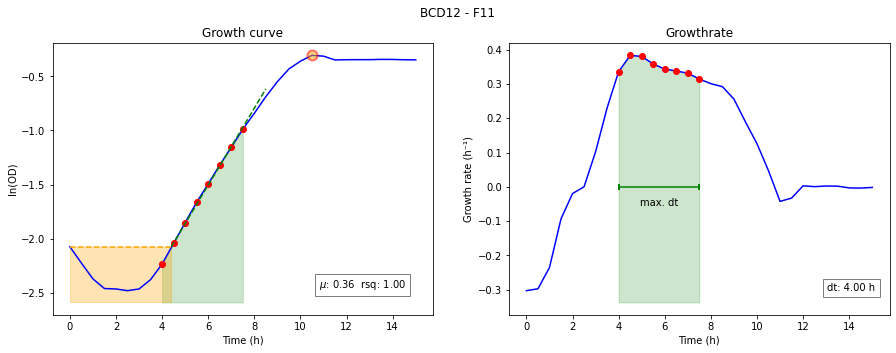

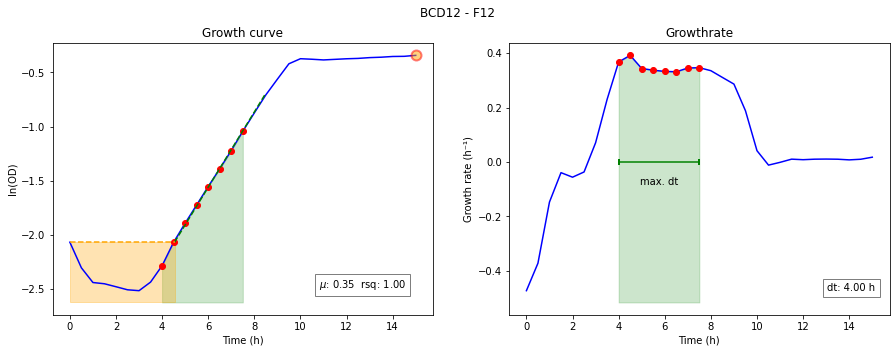

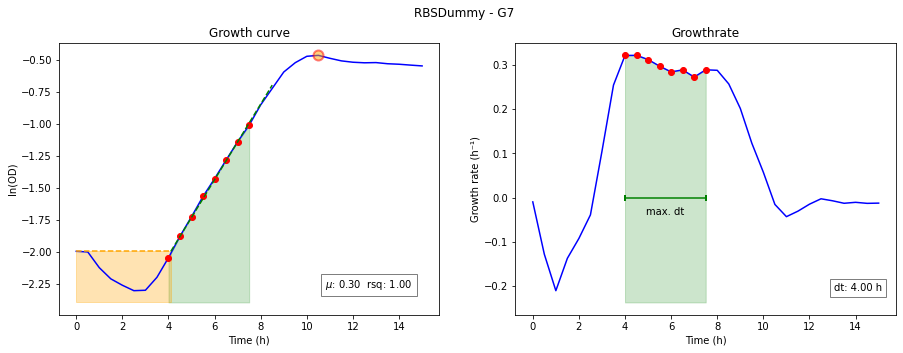

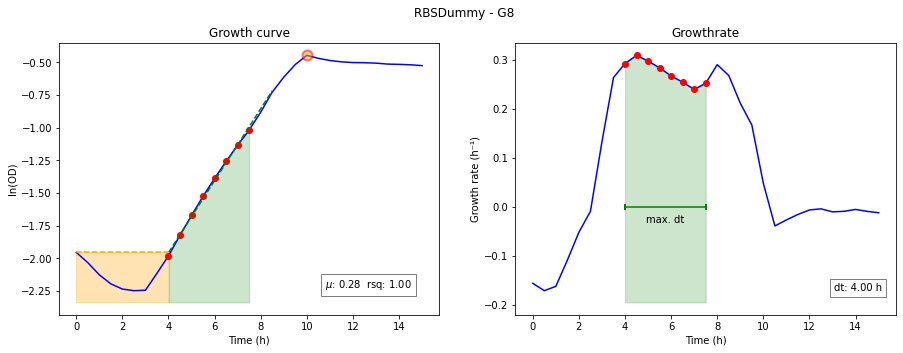

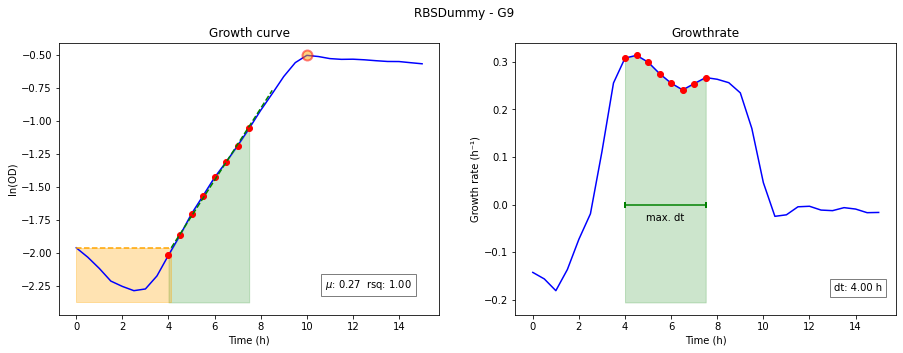

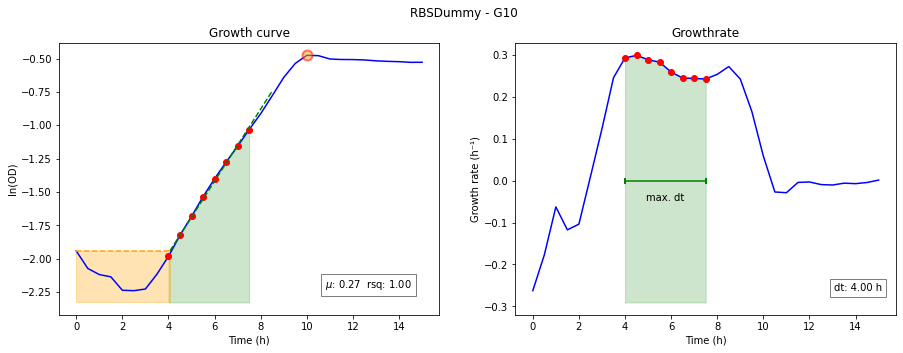

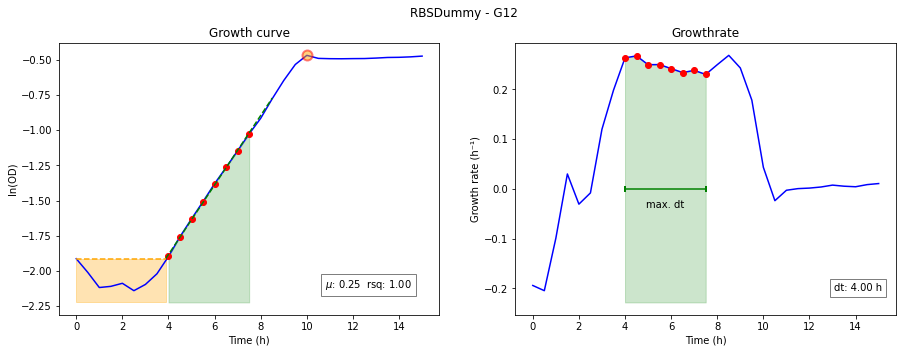




Sample       Well     μ        Max OD   Lag     
----         ----     ----     ----     ----    
B0034        G1       0.37     0.71     4.27    
B0034        G2       0.4      0.75     4.37    
B0034        G3       0.42     0.74     4.31    
B0034        G4       0.4      0.7      4.59    
B0034        G5       0.38     0.7      4.4     
B0034        G6       0.37     0.67     4.38    
----
Mean         ---      0.389    0.713    4.385   
SD           ---      0.018    0.027    0.1     
----

BCD2         F1       0.33     0.76     4.23    
BCD2         F2       0.35     0.75     4.58    
BCD2         F3       0.36     0.81     4.52    
BCD2         F4       0.34     0.76     4.57    
BCD2         F5       0.34     0.83     4.54    
BCD2         F6       0.33     0.8      4.46    
----
Mean         ---      0.34     0.785    4.485   
SD           ---      0.01     0.031    0.121   
----

BCD12        F7       0.37     0.78     4.44    
BCD12        F8       0.37     0.76     4.54

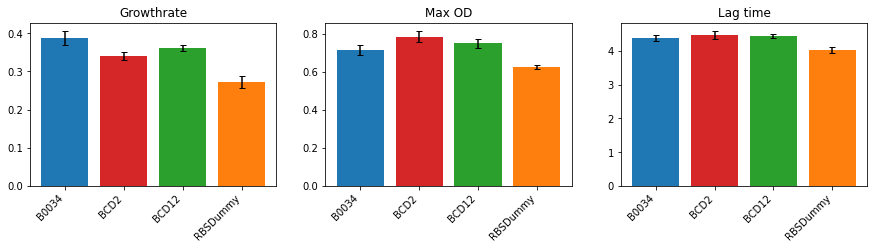

In [76]:
#plot the algorithm selection outputs for time window selection and growthrate calculations
growth_data = {}
growth_data_wells = {}
max_od = {}
lag = {}
for sample in samples_def:
    sample_name = sample[0]
    tpoints = algorithm_tpoints_sample[sample_name]
    wpoints = algorithm_wpoints_sample[sample_name]
    dt = algorithm_dt_sample[sample_name]
    for well in sample[1]:
        dataset_raw = DF_def['OD'][well]
        data = dataset_raw.astype(float)    
        sample_od = data
        sample_log2 = np.log2(data)
        sample_ln = np.log(data)
        
        gr_grad = np.gradient(sample_log2, bouts)
        gr_list = gr_grad

        gr_ln_grad = np.gradient(sample_ln, bouts)
        gr_ln_list = gr_ln_grad

        time_points = tpoints
        w_points = wpoints
        
        od_points = sample_od[time_points]
        log2_points = sample_log2[time_points]
        ln_points = sample_ln[time_points]
        gr_points = gr_list[w_points]
        gr_ln_points = gr_ln_list[w_points]

        #print(w_indices, w_time, w_od, w_log2, w_ln, w_gr, w_gr_ln, dt)

        reg = stats.linregress(time_points, ln_points)
        slope = reg[0] 
        rsq = reg[2]**2
        intercept = reg[1]     

        growth_data.update({('%s_%s' %(sample[0], well)) : (slope, rsq, intercept)})
        growth_data_wells.update({well : (slope, rsq, intercept)})

        max_od_datapoint = max(dataset_raw)
        max_od.update({well : max_od_datapoint})

        #PLOTTING MODULE--------------------------------------------------------------------------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        fig.suptitle('%s - %s' %(sample[0], well))

        #AX1: lnOD vs. time in blue, alg points in red with fit line in green and fill between. Lag in orange. Mu and Rsq
        ax1.set_title('Growth curve')
        ax1.set_xlabel('Time (h)')
        ax1.set_ylabel('ln(OD)')

        ax1.plot(time, sample_ln, 'b-')
        ax1.plot(time_points, ln_points, 'ro')
        idx_max_od = list(dataset_raw).index(max_od_datapoint)
        ax1.plot(time[idx_max_od], np.log(max_od_datapoint), color='orange', alpha=0.5, marker='o', markersize=10, markeredgecolor='r', markeredgewidth=2)

        od_0 = sample_ln[0]
        x_lag = (od_0 - intercept)/slope
        if x_lag < 0: x_lag = 0
        xn = np.linspace(x_lag, time_points[-1]+1)
        lag.update({well : x_lag})
        yn = slope * xn + intercept
        ax1.plot(xn, yn, 'g--')

        xl = np.linspace(0, x_lag)
        yl = 0 * xl + od_0
        ax1.plot(xl, yl, '--', color='orange')

        ylim_down = ax1.get_ylim()[0]
        ax1.fill_between(time_points, ln_points, ylim_down, alpha=0.2, color='g')
        ax1.fill_between(xl, yl, ylim_down, alpha=0.3, color='orange')

        ax1.text(0.7, 0.1,
                ('$\mu$: %3.2f  rsq: %3.2f' %(round(slope,2), round(rsq,2))),
                 transform=ax1.transAxes,
                 bbox=dict(facecolor='w', alpha=0.5))
        #AX2: gr(ln) vs. time in blue, alg points in red, fill between in green with error bar for dt           
        ax2.set_xlabel('Time (h)')
        ax2.set_ylabel('Growth rate (h\u207B\u00B9)')

        ax2.plot(time, gr_ln_list, 'b-')
        ax2.plot(time_points, gr_ln_points, 'ro')

        midpoint = len_list(time_points)
        ax2.errorbar(midpoint, 0, color='g', xerr=time_points[-1]-midpoint,
                     capsize=3, capthick=2)
        ax2.fill_between(time_points, gr_ln_points, ax2.get_ylim()[0], alpha=0.2, color='g')
        ax2.text(0.9, 0.1,
                ('dt: %3.2f h' %dt),
                 transform=ax2.transAxes,
                 bbox=dict(facecolor='w', alpha=0.5), va='center', ha='center')
        ax2.text(midpoint, 0+0.15*(ax2.get_ylim()[0]), 'max. dt', ha='center')
        ax2.set_title('Growthrate')                             

        plt.show()

print('\n\n')
print('{:<12} {:<8} {:<8} {:<8} {:<8}' .format('Sample', 'Well', '\u03BC', 'Max OD', 'Lag'))
print('{:<12} {:<8} {:<8} {:<8} {:<8}' .format('----', '----', '----', '----', '----'))

mean_gr_def = []
mean_max_od_def = []
mean_lag_def = []

std_gr_def = []
std_max_od_def = []
std_lag_def = []


for sample in samples_def:
    name = sample[0]
    wells = sample[1]
    name_def_list = []
    for well in wells:
        name_def = str('%s_%s' %(name, well))
        name_def_list.append(name_def)
        s = growth_data[name_def]
        print('{:<12} {:<8} {:<8} {:<8} {:<8}' .format(name,
                                                       well,
                                                       (round (s[0], 2) if s[0] != None else 'None'),
                                                       (round(max_od[well], 2) if max_od[well] != None else 'None'),
                                                       (round(lag[well], 2) if lag[well] != None else 'None')))
    print('----')

    mean_gr = np.mean([growth_data[i][0] for i in name_def_list if growth_data[i][0] != None])
    mean_max_od = np.mean([max_od[i] for i in wells if max_od[i] != None])
    mean_lag = np.mean([lag[i] for i in wells if lag[i] != None])

    std_gr = np.std([growth_data[i][0] for i in name_def_list if growth_data[i][0] != None])
    std_max_od = np.std([max_od[i] for i in wells if max_od[i] != None])
    std_lag = np.std([lag[i] for i in wells if lag[i] != None])

    mean_gr_def.append(mean_gr)
    mean_max_od_def.append(mean_max_od)
    mean_lag_def.append(mean_lag)
    std_gr_def.append(std_gr)
    std_max_od_def.append(std_max_od)
    std_lag_def.append(std_lag)

    print('{:<12} {:<8} {:<8} {:<8} {:<8}' .format('Mean', '---', round(mean_gr, 3), round(mean_max_od, 3), round(mean_lag, 3)))
    print('{:<12} {:<8} {:<8} {:<8} {:<8}' .format('SD', '---', round(std_gr, 3), round(std_max_od, 3), round(std_lag, 3)))
    print('----')
    print('')
               
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:cyan', 'tab:purple', 'tab:pink', 'tab:brown', 'tab:olive', 'lightcoral', 'seagreen', 'mediumpurple', 'gold', 'sandybrown', 'deepskyblue', 'palegreen']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))

try:
    ax1.bar(sample_names, mean_gr_def, yerr=std_gr_def, capsize=3, color=colors)
    ax1.set_xticklabels(sample_names, rotation=45, ha='right')
    ax1.set_title('Growthrate')
except:
    pass

try:
    ax2.bar(sample_names, mean_max_od_def, yerr=std_max_od_def, capsize=3, color=colors)
    ax2.set_xticklabels(sample_names, rotation=45, ha='right')
    ax2.set_title('Max OD')
except:
    pass

try:
    ax3.bar(sample_names, mean_lag_def, yerr=std_lag_def, capsize=3, color=colors)
    ax3.set_xticklabels(sample_names, rotation=45, ha='right')
    ax3.set_title('Lag time')
except:
    pass

plt.show()

## Fluorescence computations

In [85]:
#dropdown menu to select sample to be plotted
print('Indicate fluorescence dataset to analyze: ')
datasets_without_growth = dfs_names.copy()
datasets_without_growth.remove('OD')
linear_dataset = widgets.RadioButtons(
    options=datasets_without_growth,
    description='Dataset: ',
    disabled=False)
display(linear_dataset)

Indicate fluorescence dataset to analyze: 


RadioButtons(description='Dataset: ', options=('RFP',), value='RFP')

### Checking linearity between fluorescence and growth

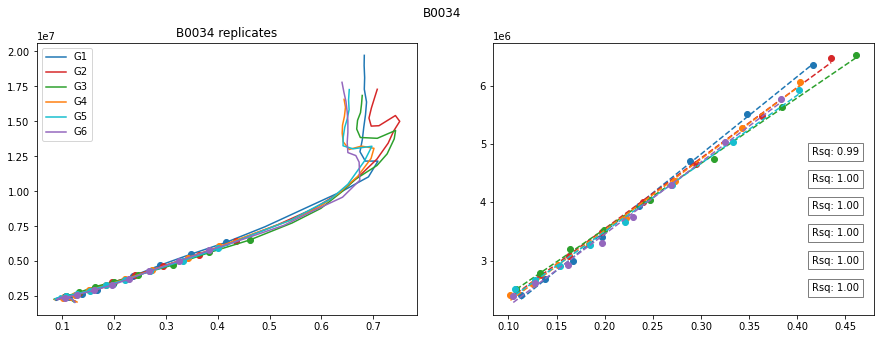

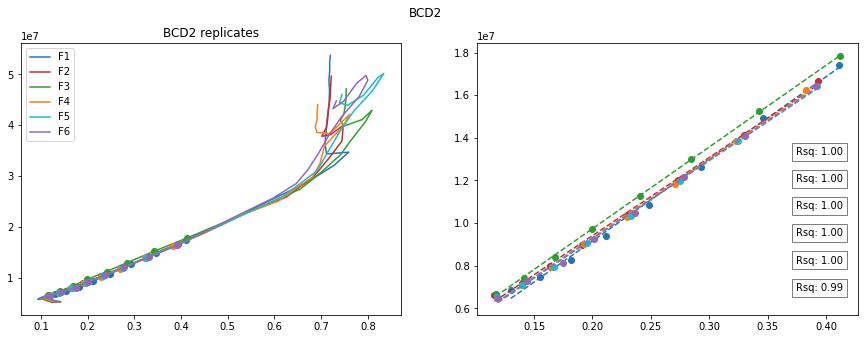

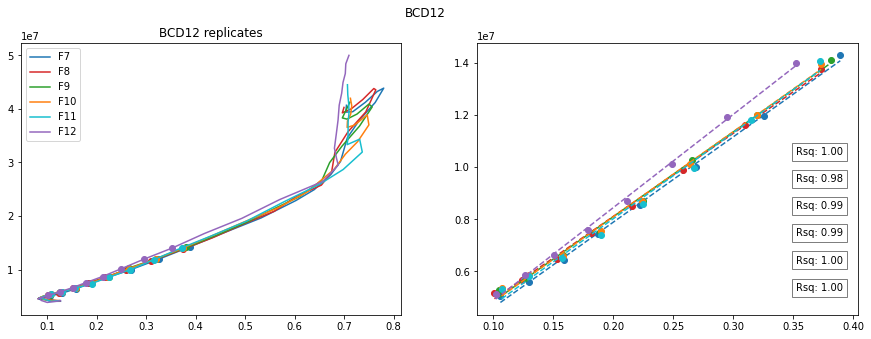

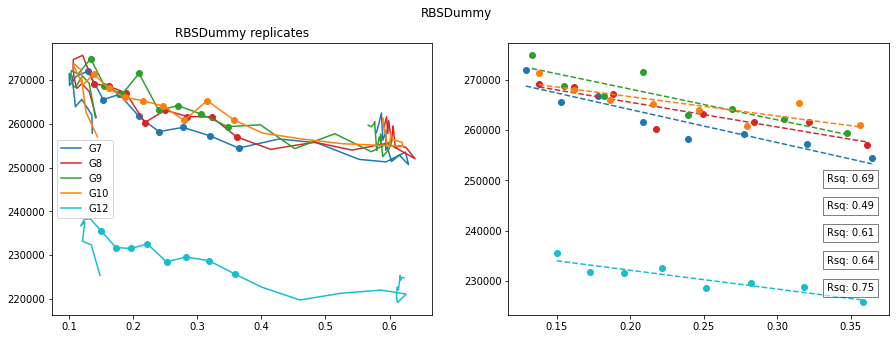

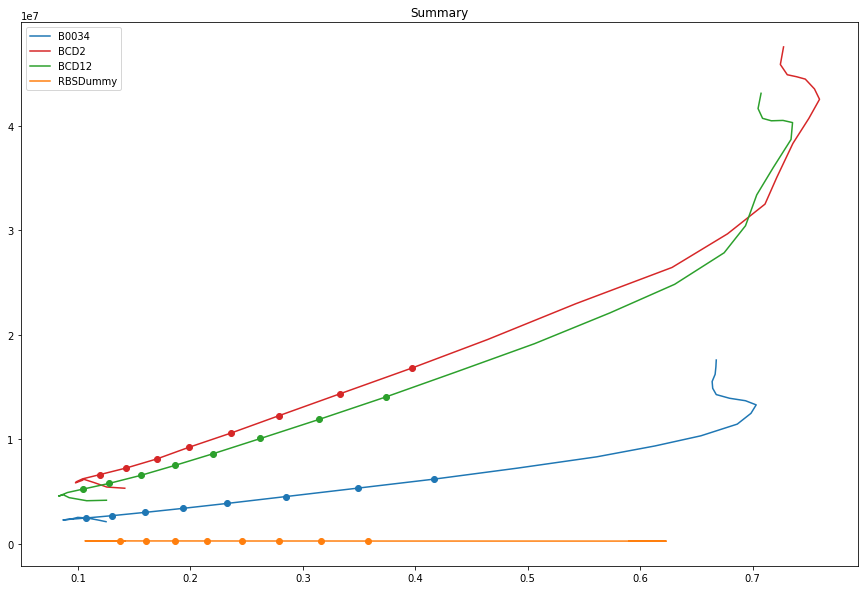

To remove replicates, uncheck the corresponding box above


In [82]:
fp_vs_od = {}

#plot each replicate and the mean + std
linear = linear_dataset.value

dataset_growth = DF_def[growth]
dataset_lin = DF_def[linear]

dataset_means_growth = DF_means['OD']
dataset_stds_growth = DF_stds['OD']
dataset_means_lin = DF_means[linear]
dataset_stds_lin = DF_stds[linear]

for sample in samples_def:   
    name = sample[0]
    wells = sample[1]
    sample = sample[0]
    
    tpoints = algorithm_tpoints_sample[sample]  

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(sample)        
        
    for i, well in enumerate(wells):
        
        w_time = tpoints
        time1, time2 = w_time[0], w_time[-1]
        w_od = dataset_growth[well][tpoints]
        fp_pts = dataset_lin[well][tpoints]

        ax1.plot(w_od, fp_pts, 'o', color=colors[i])
        ax1.plot(dataset_growth[well], dataset_lin[well], color=colors[i], label=well)

        ax2.plot(w_od, fp_pts, 'o', color=colors[i])
        x = np.linspace(w_od[time1], w_od[time2])
        reg = stats.linregress(list(w_od), list(fp_pts))
        slope = reg[0] 
        rsq = reg[2]**2
        intercept = reg[1] 
        y = slope * x + intercept
        fp_vs_od.update({well : slope})
        ax2.plot(x, y, '--', color=colors[i])

        ax2.text(0.9, 0.1+0.1*i,
                ('Rsq: %3.2f' %rsq**2),
                 transform=ax2.transAxes,
                 bbox=dict(facecolor='w', alpha=0.5), va='center', ha='center')

    ax1.set_title((sample + ' replicates'))
    ax1.legend()
  
    plt.show()

fig, ax = plt.subplots(figsize=(15,10))
for idx, sample in enumerate(samples_def):
    sample = sample[0]
    tpoints = algorithm_tpoints_sample[sample]
    ax.plot(dataset_means_growth[sample], dataset_means_lin[sample], color=colors[idx], label=sample)

    w_time = tpoints
    w_od = dataset_means_growth[sample][w_time]
    fp_gens = dataset_means_lin[sample][w_time]
    ax.plot(w_od, fp_gens, 'o', color=colors[idx])
    ax.legend()
    ax.set_title('Summary')
plt.show()

### Part Activity computation

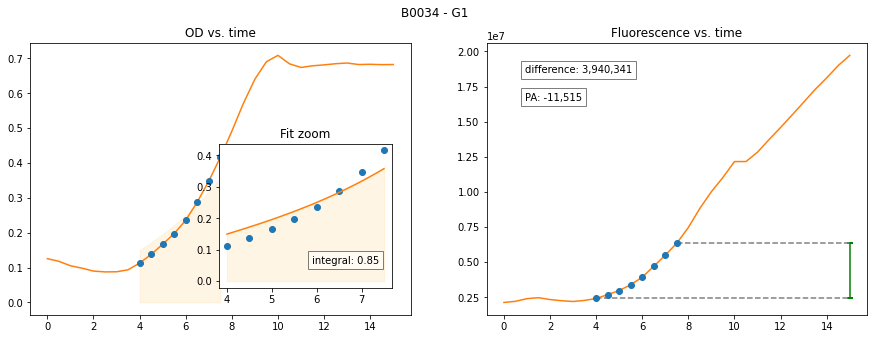

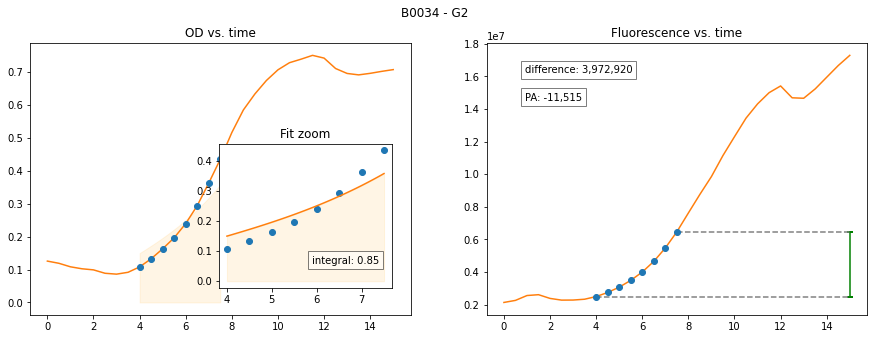

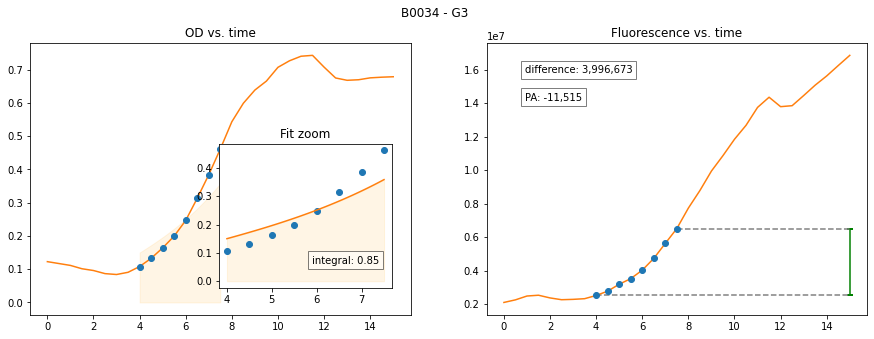

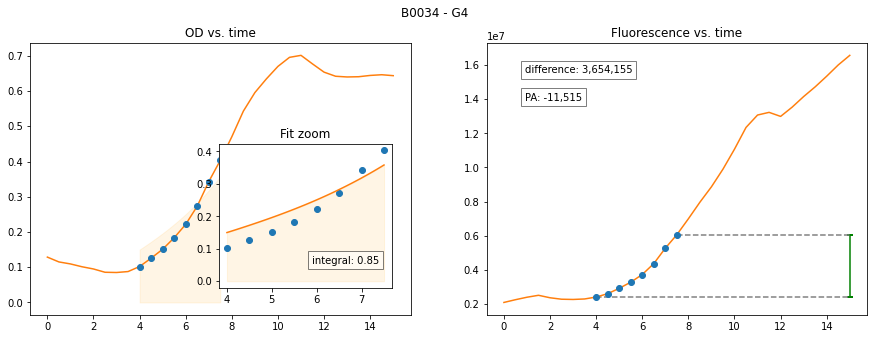

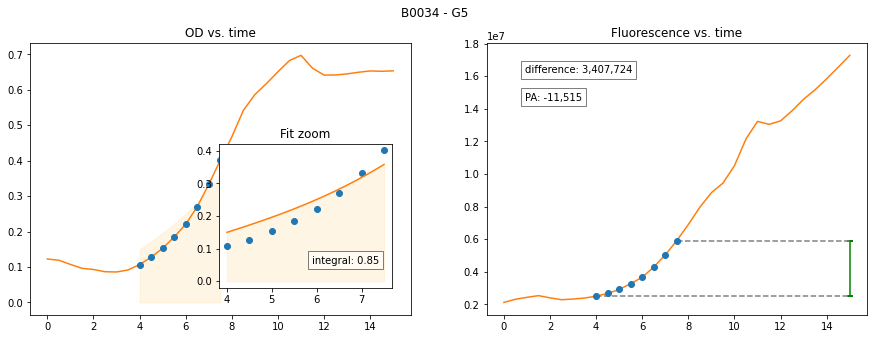

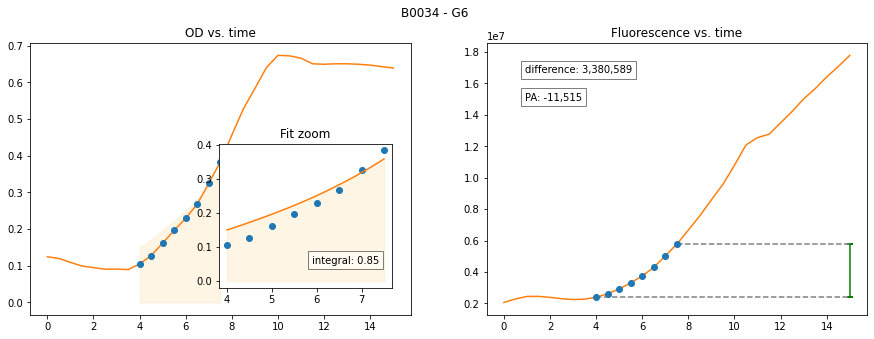

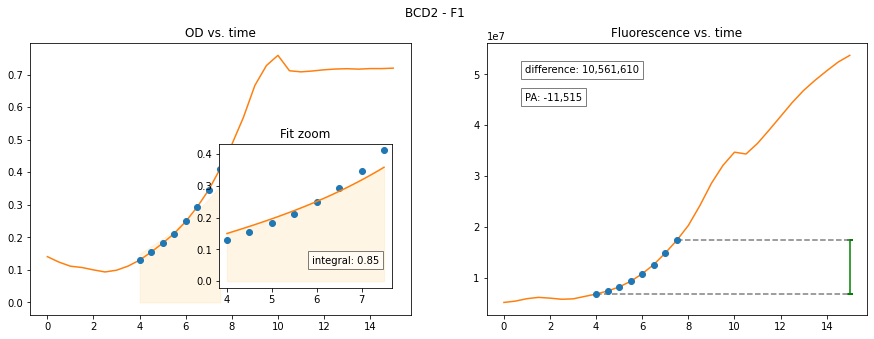

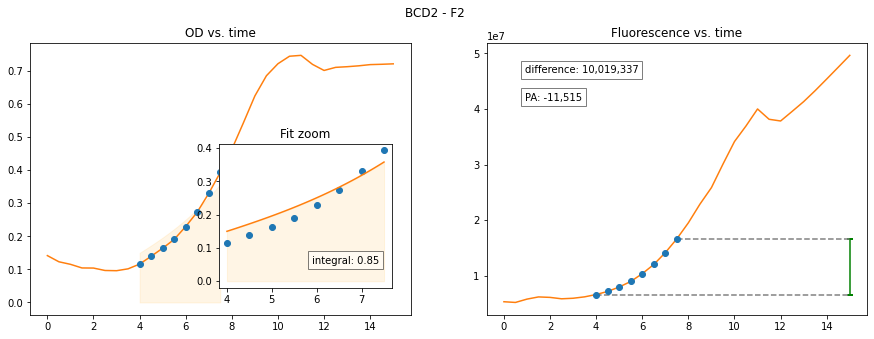

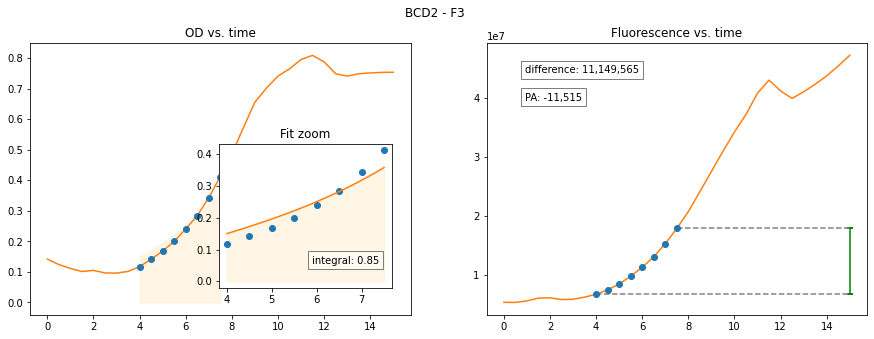

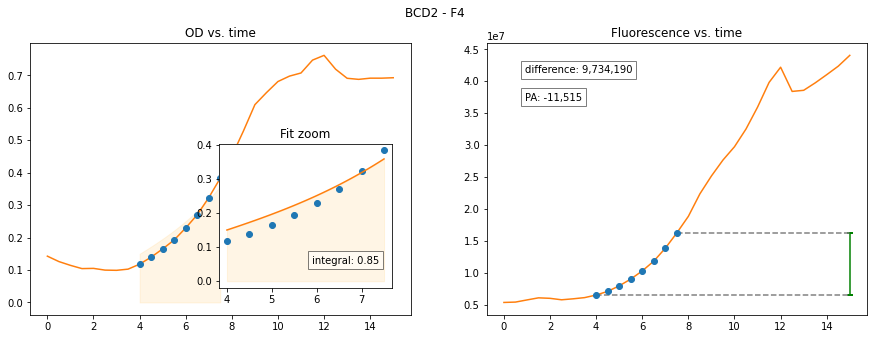

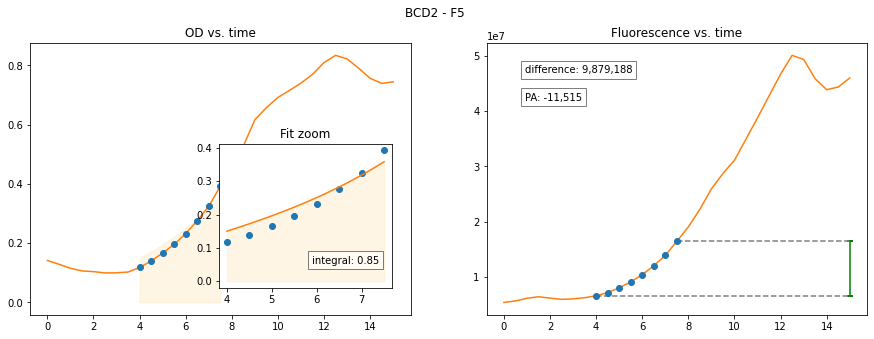

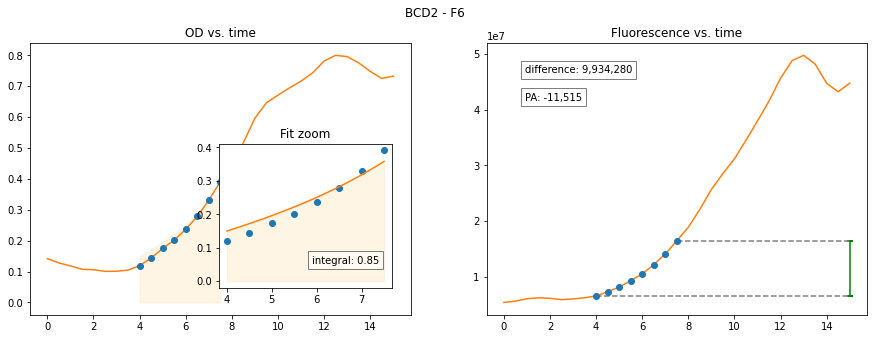

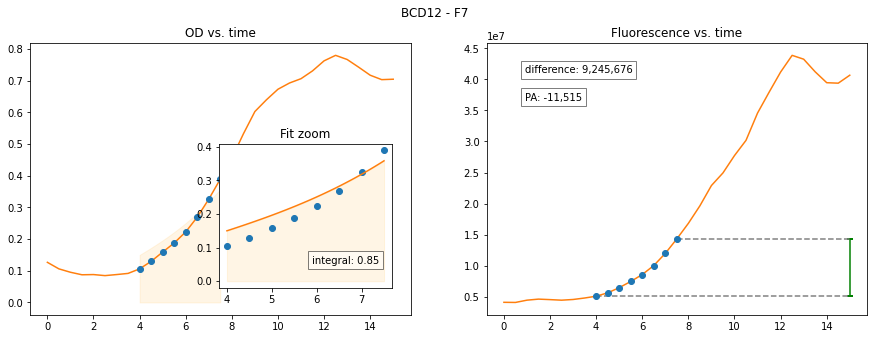

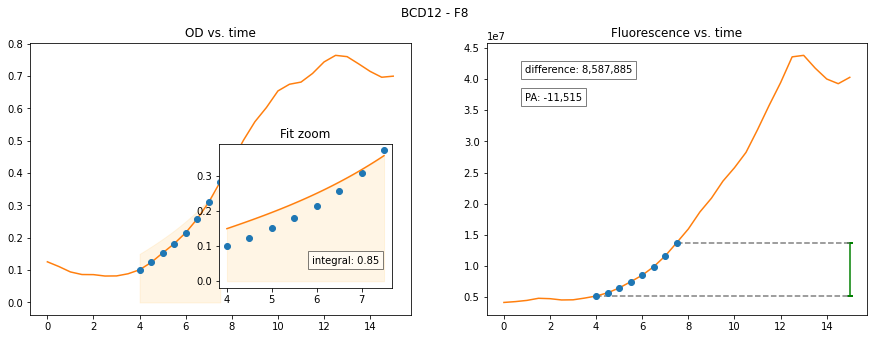

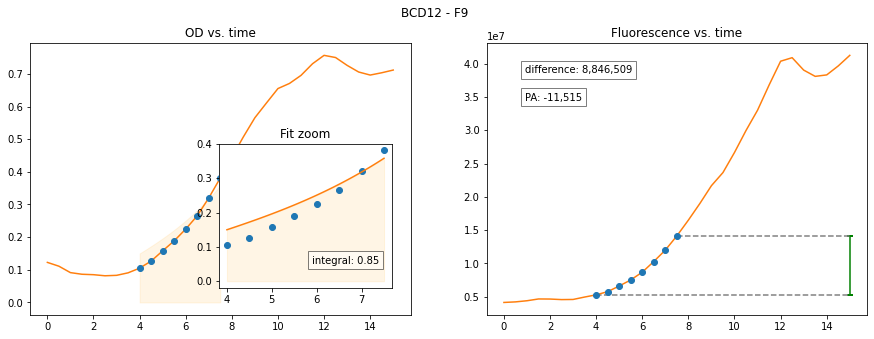

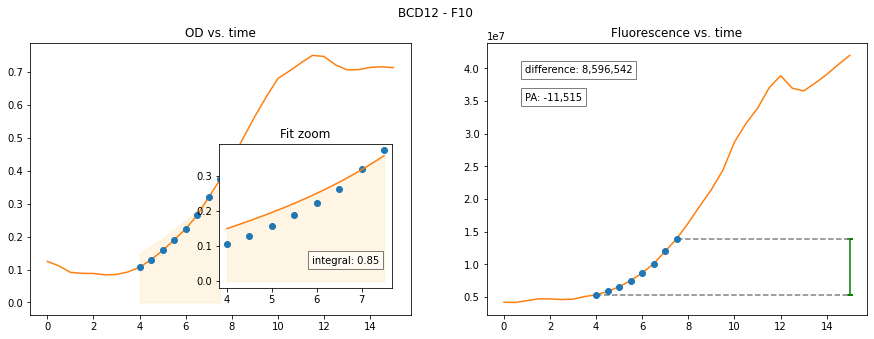

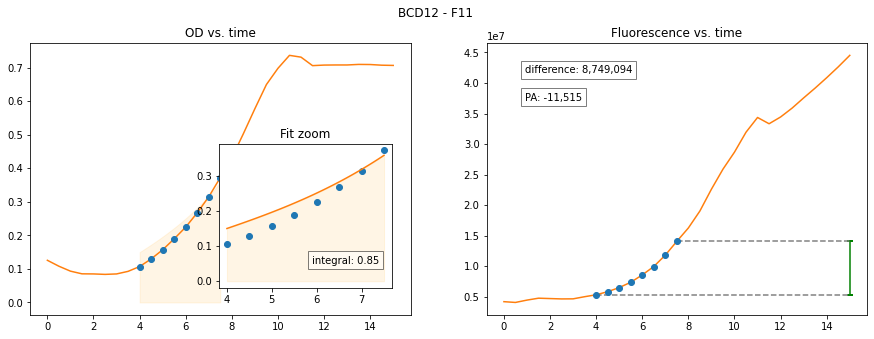

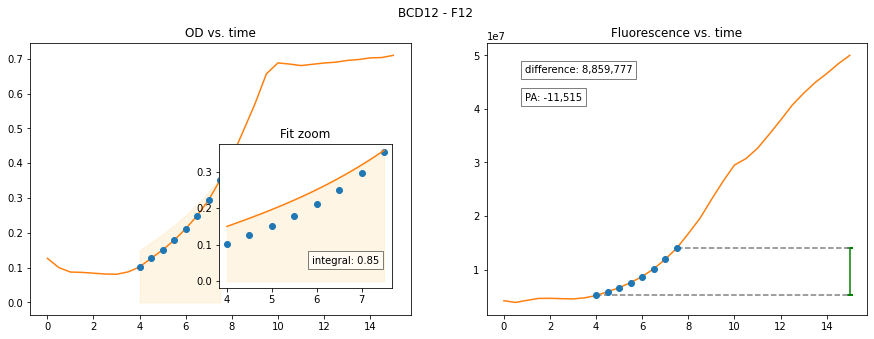

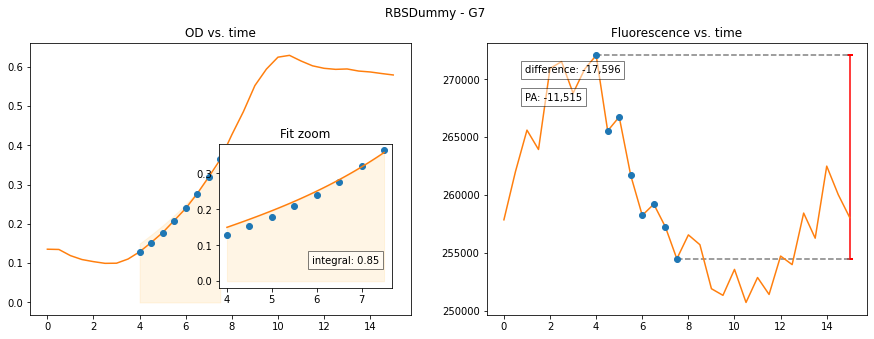

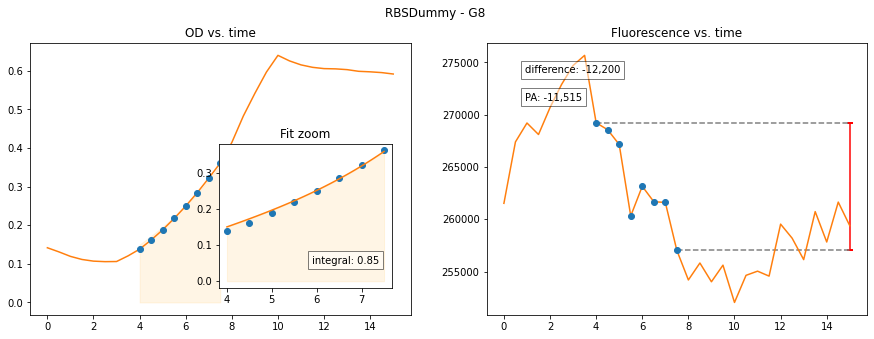

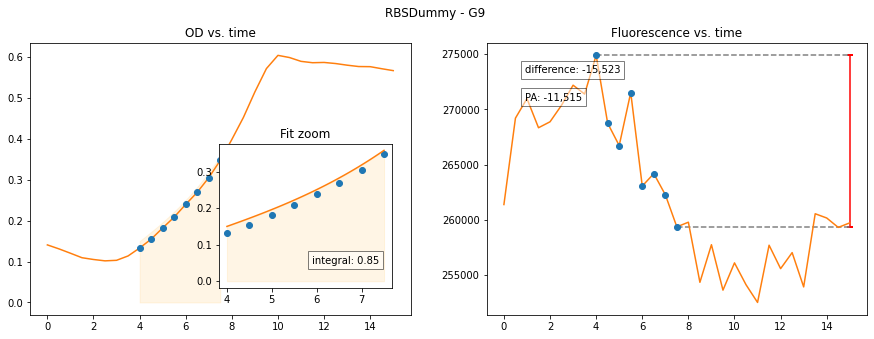

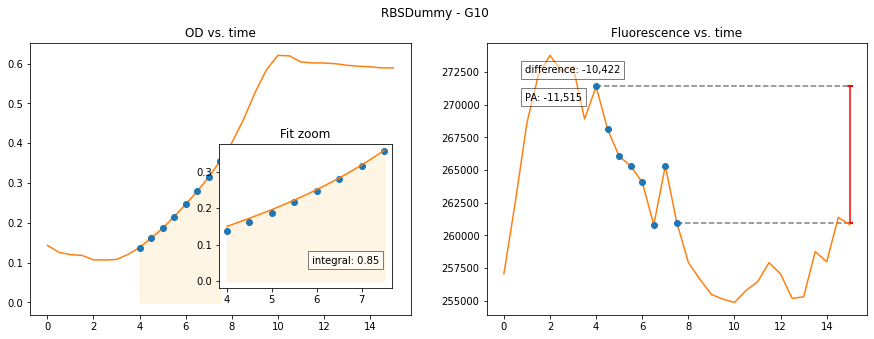

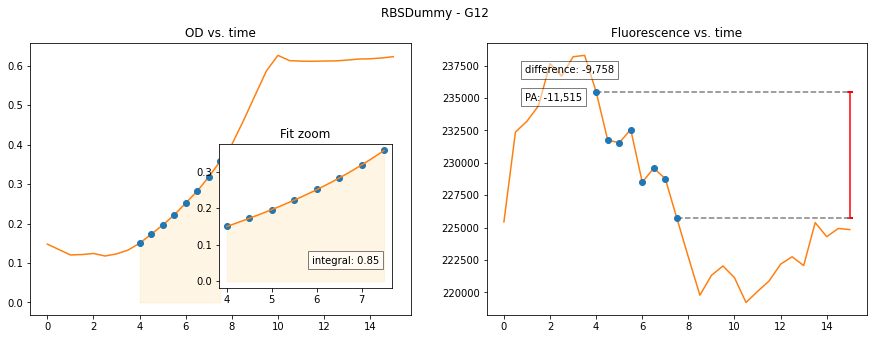

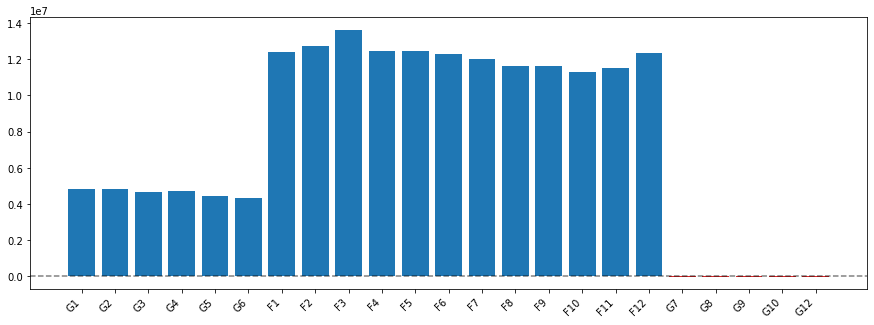

In [88]:
PA_dyn = {}

dataset_growth = DF_def['OD']
dataset_lin = DF_def[linear]
for sample in samples_def:
    sample_name = sample[0]
    tpoints = algorithm_tpoints_sample[sample_name]
    wpoints = algorithm_wpoints_sample[sample_name]

    for well in sample[1]:
        od = dataset_growth[well]
        fp = dataset_lin[well]
        
        time_idcs = list(tpoints)
        od_idcs = list(od[time_idcs])
        fp_idcs = list(fp[time_idcs])

        od1, od2 = od_idcs[0], od_idcs[-1]
        fp1, fp2 = fp_idcs[0], fp_idcs[-1]
        time1, time2 = time_idcs[0], time_idcs[-1]
        
        #Activity as mean dynamic activity
        s = str('Dynamic Activity ' + linear)
        dynact_pts = DF_def[s][well][tpoints]
        PAdyn = np.mean(dynact_pts)
        
        PA_dyn.update({well : PAdyn})

        #PLOT MODULE----------------------------------------------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        fig.suptitle('%s - %s' %(sample_name, well))
        #AX1: OD vs time. Zoom for integral.

        ax1.set_title('OD vs. time')
        ax1.plot(time, od, color='tab:orange')
        ax1.plot(time_idcs, od_idcs, 'o', color='tab:blue')
        ax1.fill_between(x, y, color='orange', alpha=0.1)

        ax3 = fig.add_axes([0.3,0.2,0.16,0.4])
        ax3.plot(time_idcs, od_idcs, 'o')
        ax3.set_title('Fit zoom')
        ax3.text(0.83, 0.2,
                ('integral: %3.2f' %integral_polyfit[0]),
                transform=ax1.transAxes,
                bbox=dict(facecolor='w', alpha=0.5), va='center', ha='center')
        ax3.plot(x, y)
        ax3.fill_between(x, y, color='orange', alpha=0.1)

        #AX2: Fluorescence vs time. Zoom for points for PA
        ax2.set_title('Fluorescence vs. time')

        midpoint = (fp1+fp2)/2
        diff = (fp2-fp1)
        mid_diff = diff/2
        if diff < 0:
            c = 'red'
        else:
            c = 'green'
        ax2.errorbar(time[-1], midpoint, color=c, yerr=mid_diff,
                     capsize=3, capthick=2)
        ax2.plot((time_idcs[0], time[-1]), (fp1, fp1), '--', color='gray')
        ax2.plot((time_idcs[-1], time[-1]), (fp2, fp2), '--', color='gray')
        ax2.plot(time, fp, color = 'tab:orange')

        ax2.plot(time_idcs, fp_idcs, 'o', color='tab:blue')

        diff_f = '{:,}'.format(int(diff))
        ax2.text(0.1, 0.9,
                ('difference: %s' %diff_f),
                transform=ax2.transAxes,
                bbox=dict(facecolor='w', alpha=0.5), va='center', ha='left')

        PA_f = '{:,}'.format(int(PA_integral_polyfit))
        ax2.text(0.1, 0.8,
            ('PA: %s' %PA_f),
            transform=ax2.transAxes,
            bbox=dict(facecolor='w', alpha=0.5), va='center', ha='left')

        plt.show()
        
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar([i for i in PA_def], [PA_def[i] for i in PA_def], color=['tab:red' if PA_def[i] < 0 else 'tab:blue' for i in PA_def])
ax.set_xticklabels([i for i in PA_def], rotation=45, ha='right')
ax.axhline(0, color='black', ls='--', alpha=0.5)
plt.show()

Sample   Well     Part Activity
------   ----     --------------
B0034    G1        4656558.4
B0034    G2        4657277.9
B0034    G3        4649539.0
B0034    G4        4468263.9
B0034    G5        4131493.5
B0034    G6        4225170.3
----
Mean               4464717.2
STD                 214660.6
----


BCD2     F1       11754684.0
BCD2     F2       12044465.8
BCD2     F3       13211504.1
BCD2     F4       11814799.2
BCD2     F5       11768062.2
BCD2     F6       11720194.3
----
Mean              12052284.9
STD                 529131.8
----


BCD12    F7       11391608.5
BCD12    F8       11140773.4
BCD12    F9       11120224.5
BCD12    F10      10778793.1
BCD12    F11      10765435.7
BCD12    F12      12201209.6
----
Mean              11233007.5
STD                 484549.8
----


RBSDummy G7         -21157.3
RBSDummy G8         -20186.5
RBSDummy G9         -16430.3
RBSDummy G10        -12130.5
RBSDummy G12        -14491.0
----
Mean                -16879.1
STD                   33

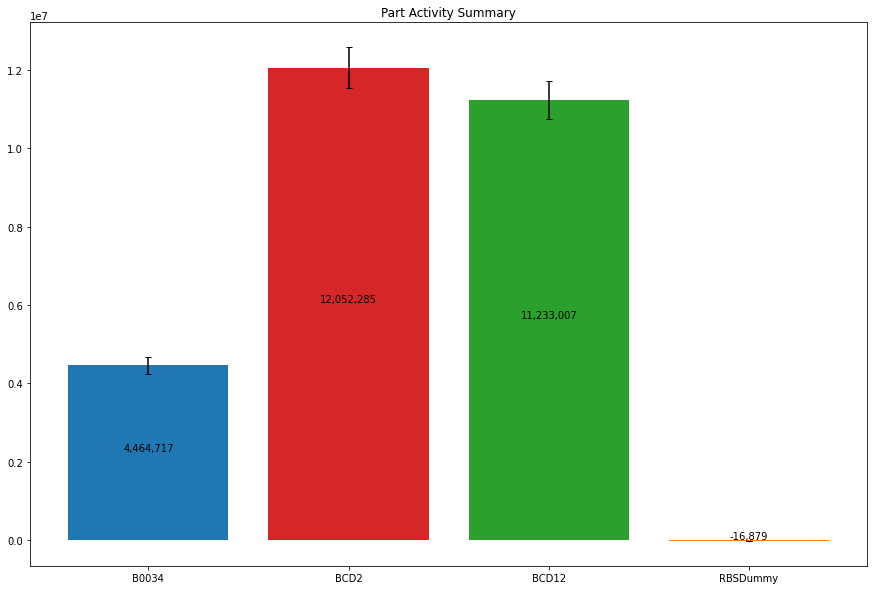

In [100]:
samples_def_withoutNones = []
for sample in samples_def:
    name = sample[0]
    wells_copy = sample[1].copy()
    owells = PA_def.keys()
    for well in wells_copy[:]: #if we have to remove two following elements, the iterator is going to change and skip elements
        if well not in owells:
            wells_copy.remove(well)
    samples_def_withoutNones.append((name, wells_copy))
    
print('{:<8} {:<8} {:>10}' .format('Sample', 'Well', 'Part Activity'))
print('{:<8} {:<8} {:>10}' .format('------', '----', '--------------'))

mean_PA_dyn_def = []
std_PA_dyn_def = []

for sample in samples_def_withoutNones:
    name = sample[0]
    wells = sample[1]
    name_def_list = []
    for well in wells:
        k = PA_def[well]
        l = PA_LL[well]
        d = PA_dyn[well]
        print('{:<8} {:<8} {:>10}' .format(name, well, round(d, 1)))
    print('----')
    
    mean_PA_dyn = np.mean([PA_dyn[i] for i in wells])
    std_PA_dyn = np.std([PA_dyn[i] for i in wells])

    mean_PA_dyn_def.append(mean_PA_dyn)
    std_PA_dyn_def.append(std_PA_dyn)

    print('{:<8} {:<8} {:>10}' .format('Mean', '', round(mean_PA_dyn, 1)))
    print('{:<8} {:<8} {:>10}' .format('STD', '', round(std_PA_dyn, 1)))
    print('----')
    print('\n')
    

fig, ax = plt.subplots(figsize=(15,10))
bars = ax.bar(sample_names, mean_PA_dyn_def, yerr=std_PA_dyn_def, capsize=3, color=colors)
for bar in bars:
    h = round(bar.get_height())
    plt.text(bar.get_x() + bar.get_width() / 2.0, h-0.5*h, '{:,}'.format(h), ha='center', va='bottom', color='black')
plt.title('Part Activity Summary')
plt.show()

In [101]:
header = ['Sample', 'Well', 'Growthrate', 'Max_OD', 'Lag', 'Part_Activity']
file = input(str('Enter output file name: '))
file = file + '.csv'
with open (file, 'w', newline='') as f:
    csv.writer(f).writerow(header)
    for sample in samples_def:
        name = sample[0]
        for well in sample[1]:
            csv.writer(f).writerow((name,
                                    well,
                                    growth_data_wells[well][0],
                                    max_od[well],
                                    lag[well],
                                    PA_dyn[well]))

print('\nFile created successfully')

Enter output file name: asdfasdfasdfasdfasdf

File created successfully
